 ## Download from google drive & create json file



In [1]:
# !gdown 1VFZDI21HXbVQRJOawGxAiQZxFERysLC4 -O datasets.zip

# !unzip ./datasets.zip

In [2]:
# import os
# import json

# # Set the path to data directory
# data_dir = "./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# base_dir = "MICCAI_BraTS2020_TrainingData/"
# # Get a list of all directories in the data directory
# all_dirs = os.listdir(data_dir)

# # Create a list of all file paths by joining data directory and directory names
# all_paths = [os.path.join(data_dir, d) for d in all_dirs]

# # Calculate sizes for training, validation, and test sets
# size = len(all_paths)
# train_size = int(0.7 * size)
# val_size = int(0.1 * size)

# # Split the file paths into training, validation, and test sets
# train_files = all_paths[:train_size]
# val_files = all_paths[train_size:train_size + val_size]
# test_files = all_paths[train_size + val_size:]

# # Function to extract ID from file path
# def extract_id_from_path(file_path):
#     return file_path.split("/")[-1]

# # Create a list for training samples
# training_samples = []
# for file_path in train_files:
#     id = extract_id_from_path(file_path)
#     if "csv" in id:
#       continue
#     sample = {
#         "fold": 0,  # Set fold to 0 to indicate it's in the training set
#         "image": [
#             os.path.join(base_dir, f"{id}/{id}_flair.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t2.nii")
#         ],
#         "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
#     }
#     training_samples.append(sample)

# # Create a list for validation samples
# validation_samples = []
# for file_path in val_files:
#     id = extract_id_from_path(file_path)
#     if "csv" in id:
#       continue
#     sample = {
#         "fold": 1,  # Set fold to 1 to indicate it's in the validation set
#         "image": [
#             os.path.join(base_dir, f"{id}/{id}_flair.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t2.nii")
#         ],
#         "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
#     }
#     validation_samples.append(sample)

# # Create a list for test samples
# test_samples = []
# for file_path in test_files:
#     id = extract_id_from_path(file_path)
#     if "csv" in id:
#       continue
#     sample = {
#         "fold": 2,  # Set fold to 2 to indicate it's in the test set
#         "image": [
#             os.path.join(base_dir, f"{id}/{id}_flair.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t2.nii")
#         ],
#         "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
#     }
#     test_samples.append(sample)

# # Combine all samples into one list
# all_samples = training_samples + validation_samples + test_samples

# # Create JSON data structure
# all_data = {"training": all_samples}

# # Convert the dictionary to a JSON string
# json_data = json.dumps(all_data, indent=4)

# # Write the JSON string to a file
# with open('brats20_folds.json', 'w') as json_file:
#     json_file.write(json_data)


## Setup environment

In [3]:
# !pip install -r requirements.txt

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [5]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SegResNet
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch
from tqdm import tqdm


print_config()

MONAI version: 0.8.1+271.g07de215c
Numpy version: 1.23.5
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 07de215caf79dabec20ac53fb38d9f2df36f182a
MONAI __file__: /home/pippi/anaconda3/envs/DLCV/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: 2.14.0
gdown version: 4.7.1
TorchVision version: 0.13.1
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpxf10cv61


## Setup average meter, fold reader, checkpoint saver

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

# Add test data
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
                #print([os.path.join(basedir, iv) for iv in d[k]])
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    test = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        elif "fold" in d and d["fold"] == 2:
            test.append(d)
        else:
            tr.append(d)

    return tr, val, test


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

## Setup dataloader

In [8]:
# Add test dataloader
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files, test_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    print(len(train_files), len(validation_files), len(test_files))
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    test_ds = data.Dataset(data=test_files, transform=val_transform)
    test_loader = data.DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

## Set dataset root directory and hyper-parameters

The following hyper-parameters are set for the purpose of this tutorial. However, additional changes, as described below, maybe beneficial.

If GPU memory is not sufficient, reduce sw_batch_size to 2 or batch_size to 1.

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.

In [9]:
data_dir = "./BraTS2020_TrainingData"
json_list = "./brats20_folds.json"
roi = (128, 128, 128)
batch_size = 1
sw_batch_size = 1
fold = 1
infer_overlap = 0.5
max_epochs = 300
val_every = 10
train_loader, val_loader, test_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

257 37 75
257 37 75


## Check data shape and visualize

image shape: (240, 240, 155), label shape: (240, 240, 155)


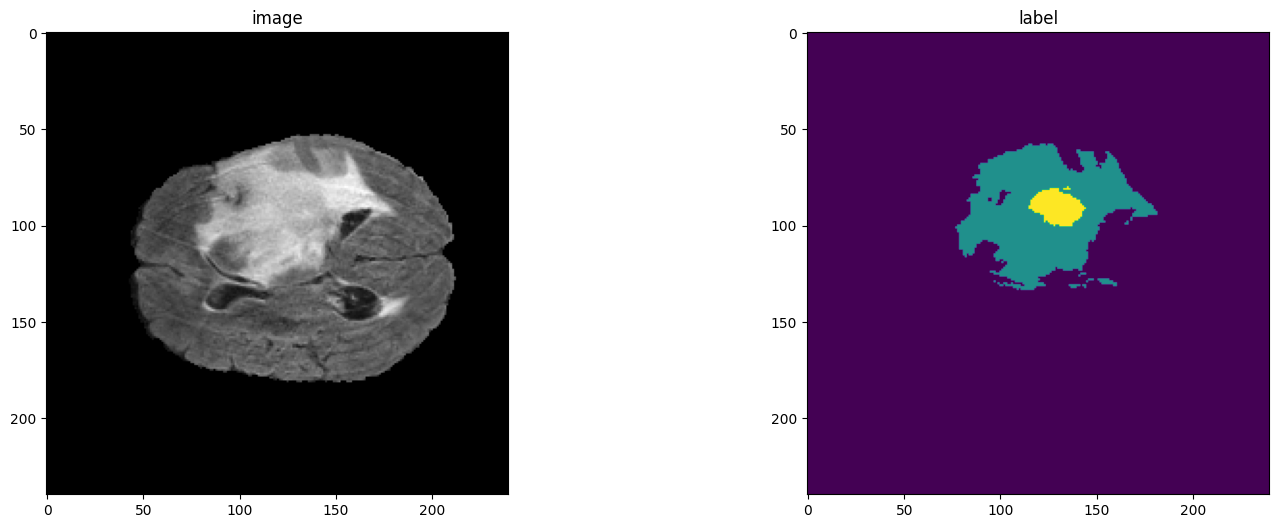

In [10]:
img_add = os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii")
label_add = os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

## Create SegResNet model

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

## Optimizer and loss function

In [12]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

## Define Train and Validation Epoch

In [13]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    # start_time = time.time()
    run_loss = AverageMeter()
    for batch_data in tqdm(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        # print(
        #     "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
        #     "loss: {:.4f}".format(run_loss.avg),
        #     "time {:.2f}s".format(time.time() - start_time),
        # )
        # start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    # start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for batch_data in tqdm(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            # print(
            #     "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            #     ", dice_tc:",
            #     dice_tc,
            #     ", dice_wt:",
            #     dice_wt,
            #     ", dice_et:",
            #     dice_et,
            #     ", time {:.2f}s".format(time.time() - start_time),
            # )
            # start_time = time.time()

    return run_acc.avg

## Define Trainer

In [14]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                    dir_add = './'
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

## Execute training

In [15]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Wed Dec  6 14:40:27 2023 Epoch: 0


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  0/299 loss: 0.9428 time 67.95s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 0/299 , dice_tc: 0.025745194 , dice_wt: 0.30957958 , dice_et: 0.092023335 , Dice_Avg: 0.14244936 , time 41.06s
new best (0.000000 --> 0.142449). 
Saving checkpoint ./model.pt
Wed Dec  6 14:42:16 2023 Epoch: 1


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  1/299 loss: 0.9186 time 64.59s
Wed Dec  6 14:43:20 2023 Epoch: 2


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  2/299 loss: 0.8908 time 65.99s
Wed Dec  6 14:44:26 2023 Epoch: 3


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  3/299 loss: 0.8418 time 64.89s
Wed Dec  6 14:45:31 2023 Epoch: 4


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  4/299 loss: 0.7935 time 62.05s
Wed Dec  6 14:46:33 2023 Epoch: 5


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  5/299 loss: 0.7343 time 64.65s
Wed Dec  6 14:47:38 2023 Epoch: 6


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  6/299 loss: 0.7108 time 62.84s
Wed Dec  6 14:48:41 2023 Epoch: 7


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  7/299 loss: 0.6396 time 63.79s
Wed Dec  6 14:49:44 2023 Epoch: 8


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  8/299 loss: 0.6366 time 67.81s
Wed Dec  6 14:50:52 2023 Epoch: 9


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  9/299 loss: 0.6095 time 64.18s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 9/299 , dice_tc: 0.45880982 , dice_wt: 0.7466995 , dice_et: 0.349871 , Dice_Avg: 0.5184601 , time 41.84s
new best (0.142449 --> 0.518460). 
Saving checkpoint ./model.pt
Wed Dec  6 14:52:38 2023 Epoch: 10


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  10/299 loss: 0.5929 time 64.77s
Wed Dec  6 14:53:43 2023 Epoch: 11


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  11/299 loss: 0.5662 time 62.04s
Wed Dec  6 14:54:45 2023 Epoch: 12


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  12/299 loss: 0.5797 time 61.96s
Wed Dec  6 14:55:47 2023 Epoch: 13


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  13/299 loss: 0.5225 time 61.44s
Wed Dec  6 14:56:49 2023 Epoch: 14


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  14/299 loss: 0.5444 time 62.03s
Wed Dec  6 14:57:51 2023 Epoch: 15


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  15/299 loss: 0.5365 time 61.51s
Wed Dec  6 14:58:52 2023 Epoch: 16


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  16/299 loss: 0.5314 time 61.40s
Wed Dec  6 14:59:53 2023 Epoch: 17


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  17/299 loss: 0.5128 time 61.37s
Wed Dec  6 15:00:55 2023 Epoch: 18


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  18/299 loss: 0.5459 time 64.51s
Wed Dec  6 15:01:59 2023 Epoch: 19


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  19/299 loss: 0.5237 time 61.71s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 19/299 , dice_tc: 0.633013 , dice_wt: 0.71963805 , dice_et: 0.5017657 , Dice_Avg: 0.61813897 , time 41.07s
new best (0.518460 --> 0.618139). 
Saving checkpoint ./model.pt
Wed Dec  6 15:03:42 2023 Epoch: 20


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  20/299 loss: 0.5210 time 63.08s
Wed Dec  6 15:04:45 2023 Epoch: 21


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  21/299 loss: 0.5175 time 62.62s
Wed Dec  6 15:05:48 2023 Epoch: 22


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  22/299 loss: 0.5286 time 62.54s
Wed Dec  6 15:06:50 2023 Epoch: 23


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  23/299 loss: 0.4963 time 61.91s
Wed Dec  6 15:07:52 2023 Epoch: 24


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  24/299 loss: 0.5373 time 62.78s
Wed Dec  6 15:08:55 2023 Epoch: 25


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  25/299 loss: 0.5350 time 63.38s
Wed Dec  6 15:09:58 2023 Epoch: 26


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  26/299 loss: 0.5001 time 61.73s
Wed Dec  6 15:11:00 2023 Epoch: 27


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  27/299 loss: 0.5156 time 61.63s
Wed Dec  6 15:12:02 2023 Epoch: 28


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  28/299 loss: 0.5377 time 61.98s
Wed Dec  6 15:13:04 2023 Epoch: 29


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  29/299 loss: 0.5129 time 62.29s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 29/299 , dice_tc: 0.65526664 , dice_wt: 0.70935154 , dice_et: 0.5430814 , Dice_Avg: 0.63589984 , time 40.37s
new best (0.618139 --> 0.635900). 
Saving checkpoint ./model.pt
Wed Dec  6 15:14:47 2023 Epoch: 30


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  30/299 loss: 0.5021 time 63.71s
Wed Dec  6 15:15:50 2023 Epoch: 31


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  31/299 loss: 0.5039 time 62.48s
Wed Dec  6 15:16:53 2023 Epoch: 32


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  32/299 loss: 0.4994 time 61.83s
Wed Dec  6 15:17:55 2023 Epoch: 33


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  33/299 loss: 0.5111 time 62.47s
Wed Dec  6 15:18:57 2023 Epoch: 34


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  34/299 loss: 0.4995 time 60.81s
Wed Dec  6 15:19:58 2023 Epoch: 35


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  35/299 loss: 0.5119 time 61.75s
Wed Dec  6 15:21:00 2023 Epoch: 36


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  36/299 loss: 0.4847 time 61.64s
Wed Dec  6 15:22:01 2023 Epoch: 37


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  37/299 loss: 0.4986 time 61.95s
Wed Dec  6 15:23:03 2023 Epoch: 38


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  38/299 loss: 0.4639 time 61.83s
Wed Dec  6 15:24:05 2023 Epoch: 39


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  39/299 loss: 0.4484 time 61.42s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 39/299 , dice_tc: 0.58844274 , dice_wt: 0.76519805 , dice_et: 0.4665603 , Dice_Avg: 0.60673374 , time 39.95s
Wed Dec  6 15:25:46 2023 Epoch: 40


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  40/299 loss: 0.4704 time 63.56s
Wed Dec  6 15:26:50 2023 Epoch: 41


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  41/299 loss: 0.4557 time 62.07s
Wed Dec  6 15:27:52 2023 Epoch: 42


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  42/299 loss: 0.4573 time 60.55s
Wed Dec  6 15:28:53 2023 Epoch: 43


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  43/299 loss: 0.4544 time 61.30s
Wed Dec  6 15:29:54 2023 Epoch: 44


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  44/299 loss: 0.4565 time 62.45s
Wed Dec  6 15:30:56 2023 Epoch: 45


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  45/299 loss: 0.4605 time 61.04s
Wed Dec  6 15:31:57 2023 Epoch: 46


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  46/299 loss: 0.4486 time 61.35s
Wed Dec  6 15:32:59 2023 Epoch: 47


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  47/299 loss: 0.4427 time 61.30s
Wed Dec  6 15:34:00 2023 Epoch: 48


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  48/299 loss: 0.4446 time 61.65s
Wed Dec  6 15:35:02 2023 Epoch: 49


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  49/299 loss: 0.4415 time 61.38s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 49/299 , dice_tc: 0.6182027 , dice_wt: 0.7166054 , dice_et: 0.49148738 , Dice_Avg: 0.6087652 , time 40.96s
Wed Dec  6 15:36:44 2023 Epoch: 50


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  50/299 loss: 0.4500 time 62.82s
Wed Dec  6 15:37:47 2023 Epoch: 51


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  51/299 loss: 0.4518 time 61.91s
Wed Dec  6 15:38:49 2023 Epoch: 52


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  52/299 loss: 0.4578 time 63.10s
Wed Dec  6 15:39:52 2023 Epoch: 53


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  53/299 loss: 0.4455 time 62.20s
Wed Dec  6 15:40:54 2023 Epoch: 54


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  54/299 loss: 0.4482 time 62.22s
Wed Dec  6 15:41:56 2023 Epoch: 55


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  55/299 loss: 0.4511 time 62.21s
Wed Dec  6 15:42:58 2023 Epoch: 56


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  56/299 loss: 0.4392 time 61.56s
Wed Dec  6 15:44:00 2023 Epoch: 57


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  57/299 loss: 0.4309 time 61.26s
Wed Dec  6 15:45:01 2023 Epoch: 58


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  58/299 loss: 0.4437 time 61.61s
Wed Dec  6 15:46:03 2023 Epoch: 59


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  59/299 loss: 0.4288 time 61.84s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 59/299 , dice_tc: 0.62942475 , dice_wt: 0.7145851 , dice_et: 0.5132332 , Dice_Avg: 0.619081 , time 40.00s
Wed Dec  6 15:47:45 2023 Epoch: 60


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  60/299 loss: 0.4281 time 62.73s
Wed Dec  6 15:48:47 2023 Epoch: 61


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  61/299 loss: 0.4237 time 62.44s
Wed Dec  6 15:49:50 2023 Epoch: 62


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  62/299 loss: 0.4310 time 62.37s
Wed Dec  6 15:50:52 2023 Epoch: 63


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  63/299 loss: 0.4478 time 63.05s
Wed Dec  6 15:51:55 2023 Epoch: 64


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  64/299 loss: 0.4419 time 61.95s
Wed Dec  6 15:52:57 2023 Epoch: 65


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  65/299 loss: 0.4370 time 63.54s
Wed Dec  6 15:54:01 2023 Epoch: 66


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  66/299 loss: 0.4722 time 61.91s
Wed Dec  6 15:55:03 2023 Epoch: 67


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  67/299 loss: 0.4424 time 61.56s
Wed Dec  6 15:56:04 2023 Epoch: 68


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  68/299 loss: 0.4730 time 61.66s
Wed Dec  6 15:57:06 2023 Epoch: 69


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  69/299 loss: 0.4297 time 61.76s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 69/299 , dice_tc: 0.6275184 , dice_wt: 0.6876313 , dice_et: 0.5561258 , Dice_Avg: 0.62375855 , time 40.23s
Wed Dec  6 15:58:48 2023 Epoch: 70


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  70/299 loss: 0.4244 time 63.94s
Wed Dec  6 15:59:52 2023 Epoch: 71


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  71/299 loss: 0.4270 time 61.96s
Wed Dec  6 16:00:54 2023 Epoch: 72


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  72/299 loss: 0.4704 time 61.01s
Wed Dec  6 16:01:55 2023 Epoch: 73


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  73/299 loss: 0.4388 time 62.23s
Wed Dec  6 16:02:57 2023 Epoch: 74


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  74/299 loss: 0.4221 time 61.52s
Wed Dec  6 16:03:59 2023 Epoch: 75


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  75/299 loss: 0.4700 time 62.60s
Wed Dec  6 16:05:01 2023 Epoch: 76


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  76/299 loss: 0.4528 time 61.44s
Wed Dec  6 16:06:03 2023 Epoch: 77


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  77/299 loss: 0.4457 time 61.18s
Wed Dec  6 16:07:04 2023 Epoch: 78


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  78/299 loss: 0.4605 time 62.61s
Wed Dec  6 16:08:06 2023 Epoch: 79


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  79/299 loss: 0.4390 time 62.79s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 79/299 , dice_tc: 0.60038316 , dice_wt: 0.72184545 , dice_et: 0.51489794 , Dice_Avg: 0.61237556 , time 40.50s
Wed Dec  6 16:09:50 2023 Epoch: 80


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  80/299 loss: 0.4487 time 62.87s
Wed Dec  6 16:10:53 2023 Epoch: 81


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  81/299 loss: 0.4378 time 62.58s
Wed Dec  6 16:11:55 2023 Epoch: 82


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  82/299 loss: 0.4693 time 63.21s
Wed Dec  6 16:12:58 2023 Epoch: 83


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  83/299 loss: 0.5557 time 61.72s
Wed Dec  6 16:14:00 2023 Epoch: 84


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  84/299 loss: 0.6987 time 61.57s
Wed Dec  6 16:15:02 2023 Epoch: 85


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  85/299 loss: 0.7393 time 61.41s
Wed Dec  6 16:16:03 2023 Epoch: 86


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  86/299 loss: 0.7236 time 62.03s
Wed Dec  6 16:17:05 2023 Epoch: 87


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  87/299 loss: 0.7721 time 62.46s
Wed Dec  6 16:18:07 2023 Epoch: 88


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  88/299 loss: 0.7621 time 61.83s
Wed Dec  6 16:19:09 2023 Epoch: 89


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  89/299 loss: 0.7380 time 61.38s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 89/299 , dice_tc: 0.0 , dice_wt: 0.543611 , dice_et: 0.0 , Dice_Avg: 0.18120366 , time 40.48s
Wed Dec  6 16:20:51 2023 Epoch: 90


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  90/299 loss: 0.7144 time 62.70s
Wed Dec  6 16:21:54 2023 Epoch: 91


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  91/299 loss: 0.7253 time 62.19s
Wed Dec  6 16:22:56 2023 Epoch: 92


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  92/299 loss: 0.6920 time 62.88s
Wed Dec  6 16:23:59 2023 Epoch: 93


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  93/299 loss: 0.7064 time 62.85s
Wed Dec  6 16:25:02 2023 Epoch: 94


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  94/299 loss: 0.7641 time 62.52s
Wed Dec  6 16:26:04 2023 Epoch: 95


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  95/299 loss: 0.7932 time 62.85s
Wed Dec  6 16:27:07 2023 Epoch: 96


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  96/299 loss: 0.8323 time 61.84s
Wed Dec  6 16:28:09 2023 Epoch: 97


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  97/299 loss: 0.8776 time 62.18s
Wed Dec  6 16:29:11 2023 Epoch: 98


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  98/299 loss: 0.8739 time 61.68s
Wed Dec  6 16:30:13 2023 Epoch: 99


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  99/299 loss: 0.8662 time 62.82s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 99/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.35s
Wed Dec  6 16:31:56 2023 Epoch: 100


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  100/299 loss: 0.8399 time 63.27s
Wed Dec  6 16:32:59 2023 Epoch: 101


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  101/299 loss: 0.8782 time 63.09s
Wed Dec  6 16:34:02 2023 Epoch: 102


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  102/299 loss: 0.8975 time 63.44s
Wed Dec  6 16:35:06 2023 Epoch: 103


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  103/299 loss: 0.8119 time 61.61s
Wed Dec  6 16:36:07 2023 Epoch: 104


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  104/299 loss: 0.8470 time 62.43s
Wed Dec  6 16:37:10 2023 Epoch: 105


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  105/299 loss: 0.8573 time 62.53s
Wed Dec  6 16:38:12 2023 Epoch: 106


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  106/299 loss: 0.8457 time 63.71s
Wed Dec  6 16:39:16 2023 Epoch: 107


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  107/299 loss: 0.8262 time 61.67s
Wed Dec  6 16:40:18 2023 Epoch: 108


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  108/299 loss: 0.8586 time 62.30s
Wed Dec  6 16:41:20 2023 Epoch: 109


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  109/299 loss: 0.8547 time 63.62s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 109/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.31s
Wed Dec  6 16:43:04 2023 Epoch: 110


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  110/299 loss: 0.8353 time 64.13s
Wed Dec  6 16:44:08 2023 Epoch: 111


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  111/299 loss: 0.8560 time 64.40s
Wed Dec  6 16:45:13 2023 Epoch: 112


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  112/299 loss: 0.8612 time 63.17s
Wed Dec  6 16:46:16 2023 Epoch: 113


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  113/299 loss: 0.8521 time 61.47s
Wed Dec  6 16:47:17 2023 Epoch: 114


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  114/299 loss: 0.8236 time 63.66s
Wed Dec  6 16:48:21 2023 Epoch: 115


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  115/299 loss: 0.8573 time 64.47s
Wed Dec  6 16:49:25 2023 Epoch: 116


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  116/299 loss: 0.8638 time 62.38s
Wed Dec  6 16:50:28 2023 Epoch: 117


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  117/299 loss: 0.8379 time 63.30s
Wed Dec  6 16:51:31 2023 Epoch: 118


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  118/299 loss: 0.8755 time 64.32s
Wed Dec  6 16:52:35 2023 Epoch: 119


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  119/299 loss: 0.8651 time 62.26s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 119/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.39s
Wed Dec  6 16:54:18 2023 Epoch: 120


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  120/299 loss: 0.8547 time 63.99s
Wed Dec  6 16:55:22 2023 Epoch: 121


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  121/299 loss: 0.8677 time 65.37s
Wed Dec  6 16:56:27 2023 Epoch: 122


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  122/299 loss: 0.8353 time 62.71s
Wed Dec  6 16:57:30 2023 Epoch: 123


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  123/299 loss: 0.8249 time 63.38s
Wed Dec  6 16:58:33 2023 Epoch: 124


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  124/299 loss: 0.8975 time 63.05s
Wed Dec  6 16:59:36 2023 Epoch: 125


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  125/299 loss: 0.8405 time 62.94s
Wed Dec  6 17:00:39 2023 Epoch: 126


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  126/299 loss: 0.8495 time 65.64s
Wed Dec  6 17:01:45 2023 Epoch: 127


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  127/299 loss: 0.8301 time 61.96s
Wed Dec  6 17:02:47 2023 Epoch: 128


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  128/299 loss: 0.8405 time 61.84s
Wed Dec  6 17:03:49 2023 Epoch: 129


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  129/299 loss: 0.8664 time 62.90s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 129/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.78s
Wed Dec  6 17:05:33 2023 Epoch: 130


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  130/299 loss: 0.8781 time 63.12s
Wed Dec  6 17:06:36 2023 Epoch: 131


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  131/299 loss: 0.8612 time 61.46s
Wed Dec  6 17:07:37 2023 Epoch: 132


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  132/299 loss: 0.8599 time 62.90s
Wed Dec  6 17:08:40 2023 Epoch: 133


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  133/299 loss: 0.8872 time 63.27s
Wed Dec  6 17:09:43 2023 Epoch: 134


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  134/299 loss: 0.8560 time 61.81s
Wed Dec  6 17:10:45 2023 Epoch: 135


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  135/299 loss: 0.8521 time 61.07s
Wed Dec  6 17:11:46 2023 Epoch: 136


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  136/299 loss: 0.8716 time 62.64s
Wed Dec  6 17:12:49 2023 Epoch: 137


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  137/299 loss: 0.8495 time 63.20s
Wed Dec  6 17:13:52 2023 Epoch: 138


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  138/299 loss: 0.8444 time 62.38s
Wed Dec  6 17:14:54 2023 Epoch: 139


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  139/299 loss: 0.8405 time 61.13s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 139/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.05s
Wed Dec  6 17:16:36 2023 Epoch: 140


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  140/299 loss: 0.8327 time 63.48s
Wed Dec  6 17:17:39 2023 Epoch: 141


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  141/299 loss: 0.8547 time 61.86s
Wed Dec  6 17:18:41 2023 Epoch: 142


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  142/299 loss: 0.8379 time 62.75s
Wed Dec  6 17:19:44 2023 Epoch: 143


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  143/299 loss: 0.8716 time 62.18s
Wed Dec  6 17:20:46 2023 Epoch: 144


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  144/299 loss: 0.8457 time 63.81s
Wed Dec  6 17:21:50 2023 Epoch: 145


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  145/299 loss: 0.8482 time 61.54s
Wed Dec  6 17:22:51 2023 Epoch: 146


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  146/299 loss: 0.8716 time 61.74s
Wed Dec  6 17:23:53 2023 Epoch: 147


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  147/299 loss: 0.8158 time 62.89s
Wed Dec  6 17:24:56 2023 Epoch: 148


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  148/299 loss: 0.8820 time 62.70s
Wed Dec  6 17:25:59 2023 Epoch: 149


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  149/299 loss: 0.8859 time 63.18s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 149/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.24s
Wed Dec  6 17:27:42 2023 Epoch: 150


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  150/299 loss: 0.8949 time 64.57s
Wed Dec  6 17:28:47 2023 Epoch: 151


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  151/299 loss: 0.8508 time 61.76s
Wed Dec  6 17:29:48 2023 Epoch: 152


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  152/299 loss: 0.8444 time 62.21s
Wed Dec  6 17:30:51 2023 Epoch: 153


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  153/299 loss: 0.8612 time 62.92s
Wed Dec  6 17:31:53 2023 Epoch: 154


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  154/299 loss: 0.8560 time 62.78s
Wed Dec  6 17:32:56 2023 Epoch: 155


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  155/299 loss: 0.8470 time 61.23s
Wed Dec  6 17:33:57 2023 Epoch: 156


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  156/299 loss: 0.8651 time 63.00s
Wed Dec  6 17:35:00 2023 Epoch: 157


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  157/299 loss: 0.8768 time 63.10s
Wed Dec  6 17:36:04 2023 Epoch: 158


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  158/299 loss: 0.8547 time 62.56s
Wed Dec  6 17:37:06 2023 Epoch: 159


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  159/299 loss: 0.8859 time 61.96s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 159/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.09s
Wed Dec  6 17:38:48 2023 Epoch: 160


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  160/299 loss: 0.8444 time 63.63s
Wed Dec  6 17:39:52 2023 Epoch: 161


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  161/299 loss: 0.8560 time 62.74s
Wed Dec  6 17:40:55 2023 Epoch: 162


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  162/299 loss: 0.8612 time 63.62s
Wed Dec  6 17:41:58 2023 Epoch: 163


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  163/299 loss: 0.8521 time 64.33s
Wed Dec  6 17:43:02 2023 Epoch: 164


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  164/299 loss: 0.8612 time 63.22s
Wed Dec  6 17:44:06 2023 Epoch: 165


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  165/299 loss: 0.8508 time 64.54s
Wed Dec  6 17:45:10 2023 Epoch: 166


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  166/299 loss: 0.8482 time 61.92s
Wed Dec  6 17:46:12 2023 Epoch: 167


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  167/299 loss: 0.8612 time 62.79s
Wed Dec  6 17:47:15 2023 Epoch: 168


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  168/299 loss: 0.8716 time 61.88s
Wed Dec  6 17:48:17 2023 Epoch: 169


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  169/299 loss: 0.8275 time 63.85s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 169/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 41.29s
Wed Dec  6 17:50:02 2023 Epoch: 170


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  170/299 loss: 0.8431 time 63.40s
Wed Dec  6 17:51:05 2023 Epoch: 171


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  171/299 loss: 0.8392 time 63.59s
Wed Dec  6 17:52:09 2023 Epoch: 172


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  172/299 loss: 0.8651 time 62.69s
Wed Dec  6 17:53:12 2023 Epoch: 173


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  173/299 loss: 0.8340 time 61.18s
Wed Dec  6 17:54:13 2023 Epoch: 174


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  174/299 loss: 0.8431 time 61.84s
Wed Dec  6 17:55:15 2023 Epoch: 175


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  175/299 loss: 0.8249 time 61.31s
Wed Dec  6 17:56:16 2023 Epoch: 176


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  176/299 loss: 0.8521 time 61.26s
Wed Dec  6 17:57:17 2023 Epoch: 177


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  177/299 loss: 0.8495 time 62.33s
Wed Dec  6 17:58:20 2023 Epoch: 178


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  178/299 loss: 0.8560 time 62.26s
Wed Dec  6 17:59:22 2023 Epoch: 179


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  179/299 loss: 0.8807 time 61.02s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 179/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.17s
Wed Dec  6 18:01:03 2023 Epoch: 180


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  180/299 loss: 0.8547 time 62.77s
Wed Dec  6 18:02:06 2023 Epoch: 181


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  181/299 loss: 0.8288 time 61.67s
Wed Dec  6 18:03:07 2023 Epoch: 182


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  182/299 loss: 0.8470 time 62.16s
Wed Dec  6 18:04:10 2023 Epoch: 183


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  183/299 loss: 0.8677 time 63.95s
Wed Dec  6 18:05:14 2023 Epoch: 184


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  184/299 loss: 0.8612 time 61.96s
Wed Dec  6 18:06:16 2023 Epoch: 185


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  185/299 loss: 0.8703 time 63.58s
Wed Dec  6 18:07:19 2023 Epoch: 186


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  186/299 loss: 0.8755 time 62.62s
Wed Dec  6 18:08:22 2023 Epoch: 187


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  187/299 loss: 0.8534 time 62.38s
Wed Dec  6 18:09:24 2023 Epoch: 188


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  188/299 loss: 0.8301 time 61.50s
Wed Dec  6 18:10:26 2023 Epoch: 189


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  189/299 loss: 0.8470 time 61.29s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 189/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.27s
Wed Dec  6 18:12:07 2023 Epoch: 190


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  190/299 loss: 0.8495 time 63.09s
Wed Dec  6 18:13:10 2023 Epoch: 191


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  191/299 loss: 0.8703 time 62.87s
Wed Dec  6 18:14:13 2023 Epoch: 192


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  192/299 loss: 0.8145 time 63.17s
Wed Dec  6 18:15:16 2023 Epoch: 193


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  193/299 loss: 0.8599 time 62.80s
Wed Dec  6 18:16:19 2023 Epoch: 194


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  194/299 loss: 0.8573 time 62.83s
Wed Dec  6 18:17:22 2023 Epoch: 195


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  195/299 loss: 0.8638 time 62.76s
Wed Dec  6 18:18:25 2023 Epoch: 196


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  196/299 loss: 0.8755 time 61.86s
Wed Dec  6 18:19:27 2023 Epoch: 197


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  197/299 loss: 0.8703 time 62.68s
Wed Dec  6 18:20:29 2023 Epoch: 198


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  198/299 loss: 0.8314 time 63.26s
Wed Dec  6 18:21:33 2023 Epoch: 199


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  199/299 loss: 0.8599 time 64.13s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 199/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.70s
Wed Dec  6 18:23:17 2023 Epoch: 200


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  200/299 loss: 0.8418 time 62.47s
Wed Dec  6 18:24:20 2023 Epoch: 201


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  201/299 loss: 0.8366 time 62.40s
Wed Dec  6 18:25:22 2023 Epoch: 202


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  202/299 loss: 0.8599 time 62.01s
Wed Dec  6 18:26:24 2023 Epoch: 203


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  203/299 loss: 0.8547 time 67.44s
Wed Dec  6 18:27:32 2023 Epoch: 204


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  204/299 loss: 0.8794 time 63.99s
Wed Dec  6 18:28:36 2023 Epoch: 205


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  205/299 loss: 0.8275 time 62.84s
Wed Dec  6 18:29:38 2023 Epoch: 206


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  206/299 loss: 0.8560 time 61.86s
Wed Dec  6 18:30:40 2023 Epoch: 207


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  207/299 loss: 0.8482 time 64.01s
Wed Dec  6 18:31:44 2023 Epoch: 208


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  208/299 loss: 0.8340 time 61.52s
Wed Dec  6 18:32:46 2023 Epoch: 209


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  209/299 loss: 0.8560 time 62.91s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 209/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.20s
Wed Dec  6 18:34:29 2023 Epoch: 210


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  210/299 loss: 0.8690 time 62.91s
Wed Dec  6 18:35:32 2023 Epoch: 211


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  211/299 loss: 0.8366 time 62.10s
Wed Dec  6 18:36:34 2023 Epoch: 212


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  212/299 loss: 0.8560 time 62.58s
Wed Dec  6 18:37:37 2023 Epoch: 213


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  213/299 loss: 0.8521 time 62.83s
Wed Dec  6 18:38:39 2023 Epoch: 214


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  214/299 loss: 0.8807 time 61.07s
Wed Dec  6 18:39:40 2023 Epoch: 215


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  215/299 loss: 0.8560 time 61.23s
Wed Dec  6 18:40:42 2023 Epoch: 216


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  216/299 loss: 0.8444 time 61.72s
Wed Dec  6 18:41:43 2023 Epoch: 217


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  217/299 loss: 0.8392 time 63.11s
Wed Dec  6 18:42:47 2023 Epoch: 218


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  218/299 loss: 0.8872 time 62.10s
Wed Dec  6 18:43:49 2023 Epoch: 219


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  219/299 loss: 0.8482 time 68.30s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 219/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.99s
Wed Dec  6 18:45:38 2023 Epoch: 220


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  220/299 loss: 0.8586 time 63.58s
Wed Dec  6 18:46:42 2023 Epoch: 221


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  221/299 loss: 0.8599 time 63.42s
Wed Dec  6 18:47:45 2023 Epoch: 222


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  222/299 loss: 0.8314 time 60.81s
Wed Dec  6 18:48:46 2023 Epoch: 223


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  223/299 loss: 0.8872 time 63.45s
Wed Dec  6 18:49:49 2023 Epoch: 224


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  224/299 loss: 0.8651 time 63.52s
Wed Dec  6 18:50:53 2023 Epoch: 225


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  225/299 loss: 0.8470 time 62.37s
Wed Dec  6 18:51:55 2023 Epoch: 226


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  226/299 loss: 0.8249 time 63.56s
Wed Dec  6 18:52:59 2023 Epoch: 227


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  227/299 loss: 0.8210 time 61.16s
Wed Dec  6 18:54:00 2023 Epoch: 228


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  228/299 loss: 0.8547 time 61.89s
Wed Dec  6 18:55:02 2023 Epoch: 229


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  229/299 loss: 0.8444 time 63.62s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 229/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.16s
Wed Dec  6 18:56:45 2023 Epoch: 230


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  230/299 loss: 0.8534 time 63.98s
Wed Dec  6 18:57:49 2023 Epoch: 231


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  231/299 loss: 0.8444 time 62.87s
Wed Dec  6 18:58:52 2023 Epoch: 232


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  232/299 loss: 0.8755 time 63.27s
Wed Dec  6 18:59:56 2023 Epoch: 233


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  233/299 loss: 0.8651 time 63.09s
Wed Dec  6 19:00:59 2023 Epoch: 234


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  234/299 loss: 0.8327 time 66.19s
Wed Dec  6 19:02:05 2023 Epoch: 235


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  235/299 loss: 0.8586 time 62.41s
Wed Dec  6 19:03:07 2023 Epoch: 236


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  236/299 loss: 0.8534 time 61.86s
Wed Dec  6 19:04:09 2023 Epoch: 237


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  237/299 loss: 0.8599 time 62.38s
Wed Dec  6 19:05:12 2023 Epoch: 238


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  238/299 loss: 0.8457 time 63.12s
Wed Dec  6 19:06:15 2023 Epoch: 239


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  239/299 loss: 0.8586 time 61.97s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 239/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.57s
Wed Dec  6 19:07:57 2023 Epoch: 240


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  240/299 loss: 0.8560 time 62.64s
Wed Dec  6 19:09:00 2023 Epoch: 241


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  241/299 loss: 0.8638 time 62.57s
Wed Dec  6 19:10:02 2023 Epoch: 242


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  242/299 loss: 0.8781 time 64.13s
Wed Dec  6 19:11:07 2023 Epoch: 243


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  243/299 loss: 0.8599 time 62.61s
Wed Dec  6 19:12:09 2023 Epoch: 244


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  244/299 loss: 0.8612 time 62.68s
Wed Dec  6 19:13:12 2023 Epoch: 245


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  245/299 loss: 0.8470 time 62.45s
Wed Dec  6 19:14:14 2023 Epoch: 246


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  246/299 loss: 0.8405 time 64.25s
Wed Dec  6 19:15:19 2023 Epoch: 247


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  247/299 loss: 0.8457 time 63.49s
Wed Dec  6 19:16:22 2023 Epoch: 248


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  248/299 loss: 0.8599 time 67.97s
Wed Dec  6 19:17:30 2023 Epoch: 249


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  249/299 loss: 0.8418 time 61.96s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 249/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 41.76s
Wed Dec  6 19:19:14 2023 Epoch: 250


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  250/299 loss: 0.8716 time 63.10s
Wed Dec  6 19:20:17 2023 Epoch: 251


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  251/299 loss: 0.8379 time 63.88s
Wed Dec  6 19:21:21 2023 Epoch: 252


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  252/299 loss: 0.8482 time 63.34s
Wed Dec  6 19:22:24 2023 Epoch: 253


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  253/299 loss: 0.8638 time 63.42s
Wed Dec  6 19:23:27 2023 Epoch: 254


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  254/299 loss: 0.8495 time 62.68s
Wed Dec  6 19:24:30 2023 Epoch: 255


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  255/299 loss: 0.8457 time 64.59s
Wed Dec  6 19:25:35 2023 Epoch: 256


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  256/299 loss: 0.8275 time 62.22s
Wed Dec  6 19:26:37 2023 Epoch: 257


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  257/299 loss: 0.8547 time 64.03s
Wed Dec  6 19:27:41 2023 Epoch: 258


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  258/299 loss: 0.8560 time 63.30s
Wed Dec  6 19:28:44 2023 Epoch: 259


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  259/299 loss: 0.8560 time 63.53s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 259/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.15s
Wed Dec  6 19:30:28 2023 Epoch: 260


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  260/299 loss: 0.8470 time 63.38s
Wed Dec  6 19:31:31 2023 Epoch: 261


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  261/299 loss: 0.8586 time 62.98s
Wed Dec  6 19:32:34 2023 Epoch: 262


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  262/299 loss: 0.8625 time 62.78s
Wed Dec  6 19:33:37 2023 Epoch: 263


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  263/299 loss: 0.8405 time 62.75s
Wed Dec  6 19:34:40 2023 Epoch: 264


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  264/299 loss: 0.8210 time 62.17s
Wed Dec  6 19:35:42 2023 Epoch: 265


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  265/299 loss: 0.8418 time 62.82s
Wed Dec  6 19:36:45 2023 Epoch: 266


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  266/299 loss: 0.8327 time 65.55s
Wed Dec  6 19:37:50 2023 Epoch: 267


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  267/299 loss: 0.8405 time 63.27s
Wed Dec  6 19:38:54 2023 Epoch: 268


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  268/299 loss: 0.8457 time 64.02s
Wed Dec  6 19:39:58 2023 Epoch: 269


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  269/299 loss: 0.8495 time 61.27s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 269/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.21s
Wed Dec  6 19:41:39 2023 Epoch: 270


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  270/299 loss: 0.8755 time 63.62s
Wed Dec  6 19:42:43 2023 Epoch: 271


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  271/299 loss: 0.8301 time 61.51s
Wed Dec  6 19:43:44 2023 Epoch: 272


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  272/299 loss: 0.8664 time 61.85s
Wed Dec  6 19:44:46 2023 Epoch: 273


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  273/299 loss: 0.8547 time 63.28s
Wed Dec  6 19:45:49 2023 Epoch: 274


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  274/299 loss: 0.8833 time 62.25s
Wed Dec  6 19:46:52 2023 Epoch: 275


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  275/299 loss: 0.8379 time 61.89s
Wed Dec  6 19:47:54 2023 Epoch: 276


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  276/299 loss: 0.8405 time 63.20s
Wed Dec  6 19:48:57 2023 Epoch: 277


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  277/299 loss: 0.8586 time 62.66s
Wed Dec  6 19:49:59 2023 Epoch: 278


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  278/299 loss: 0.8664 time 63.66s
Wed Dec  6 19:51:03 2023 Epoch: 279


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  279/299 loss: 0.8716 time 63.87s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 279/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.17s
Wed Dec  6 19:52:47 2023 Epoch: 280


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  280/299 loss: 0.8470 time 62.78s
Wed Dec  6 19:53:50 2023 Epoch: 281


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  281/299 loss: 0.8482 time 61.80s
Wed Dec  6 19:54:52 2023 Epoch: 282


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  282/299 loss: 0.8560 time 61.93s
Wed Dec  6 19:55:54 2023 Epoch: 283


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  283/299 loss: 0.8353 time 62.36s
Wed Dec  6 19:56:56 2023 Epoch: 284


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  284/299 loss: 0.8612 time 61.25s
Wed Dec  6 19:57:57 2023 Epoch: 285


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  285/299 loss: 0.8716 time 61.92s
Wed Dec  6 19:58:59 2023 Epoch: 286


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  286/299 loss: 0.8677 time 63.01s
Wed Dec  6 20:00:02 2023 Epoch: 287


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  287/299 loss: 0.8223 time 66.00s
Wed Dec  6 20:01:08 2023 Epoch: 288


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  288/299 loss: 0.8560 time 63.52s
Wed Dec  6 20:02:12 2023 Epoch: 289


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  289/299 loss: 0.8405 time 63.71s


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final validation stats 289/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.33s
Wed Dec  6 20:03:56 2023 Epoch: 290


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  290/299 loss: 0.8495 time 62.79s
Wed Dec  6 20:04:59 2023 Epoch: 291


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  291/299 loss: 0.8392 time 62.99s
Wed Dec  6 20:06:02 2023 Epoch: 292


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  292/299 loss: 0.8470 time 67.37s
Wed Dec  6 20:07:09 2023 Epoch: 293


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  293/299 loss: 0.8119 time 63.43s
Wed Dec  6 20:08:12 2023 Epoch: 294


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  294/299 loss: 0.8586 time 62.68s
Wed Dec  6 20:09:15 2023 Epoch: 295


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  295/299 loss: 0.8677 time 67.46s
Wed Dec  6 20:10:22 2023 Epoch: 296


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  296/299 loss: 0.8379 time 64.36s
Wed Dec  6 20:11:27 2023 Epoch: 297


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  297/299 loss: 0.8703 time 62.72s
Wed Dec  6 20:12:30 2023 Epoch: 298


  0%|                                                                                           | 0/257 [00:00<?, ?it/s]

Final training  298/299 loss: 0.8664 time 63.04s
Wed Dec  6 20:13:33 2023 Epoch: 299


  0%|                                                                                            | 0/37 [00:00<?, ?it/s]

Final training  299/299 loss: 0.8470 time 62.13s


100%|███████████████████████████████████████████████████████████████████████████████████| 37/37 [00:40<00:00,  1.09s/it]

Final validation stats 299/299 , dice_tc: 0.0 , dice_wt: 0.0 , dice_et: 0.0 , Dice_Avg: 0.0 , time 40.17s
Training Finished !, Best Accuracy:  0.63589984


In [16]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")
# Final validation stats 29/299 , dice_tc: 0.65526664 , dice_wt: 0.70935154 , dice_et: 0.5430814 , Dice_Avg: 0.63589984 , time 40.37s

train completed, best average dice: 0.6359 


### Plot the loss and Dice metric

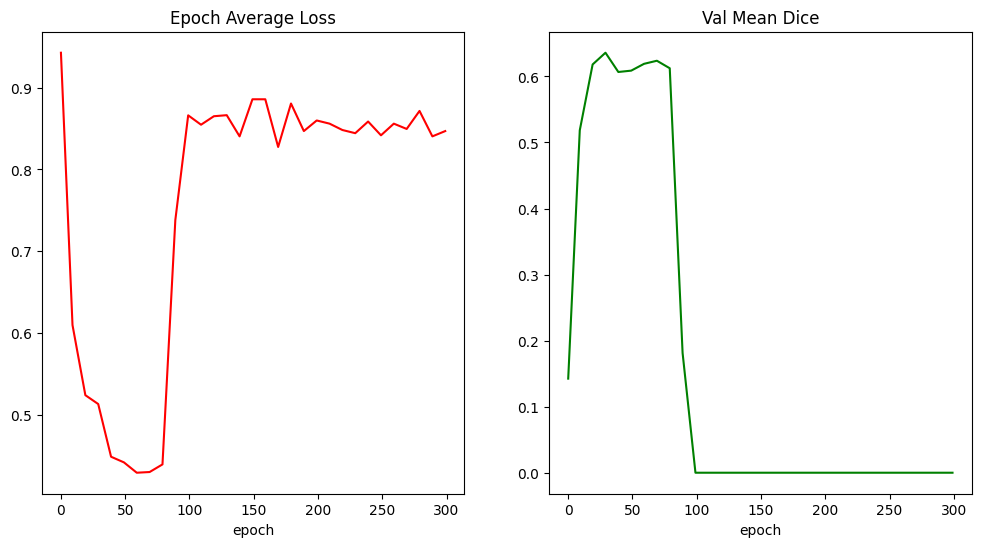

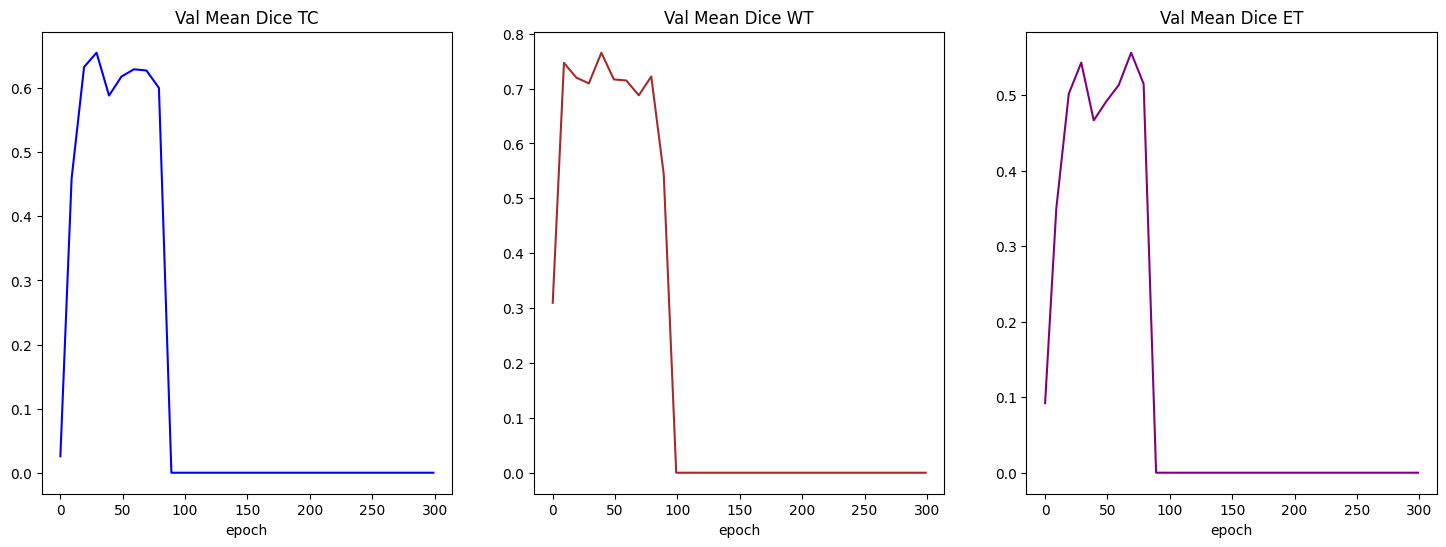

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()

## Create test set dataloader

In [18]:
case_num = "001"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1ce.nii",
            ),
            os.path.join(
                data_dir,
                "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1.nii",
            ),
            os.path.join(
                data_dir,
                "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t2.nii",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_seg.nii",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

## Load the best saved checkpoint and perform inference

We select a single case from the validation set and perform inference to compare the model segmentation output with the corresponding label.

In [20]:
model.load_state_dict(torch.load(os.path.join('./', "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

## Visualize segmentation output and compare with label

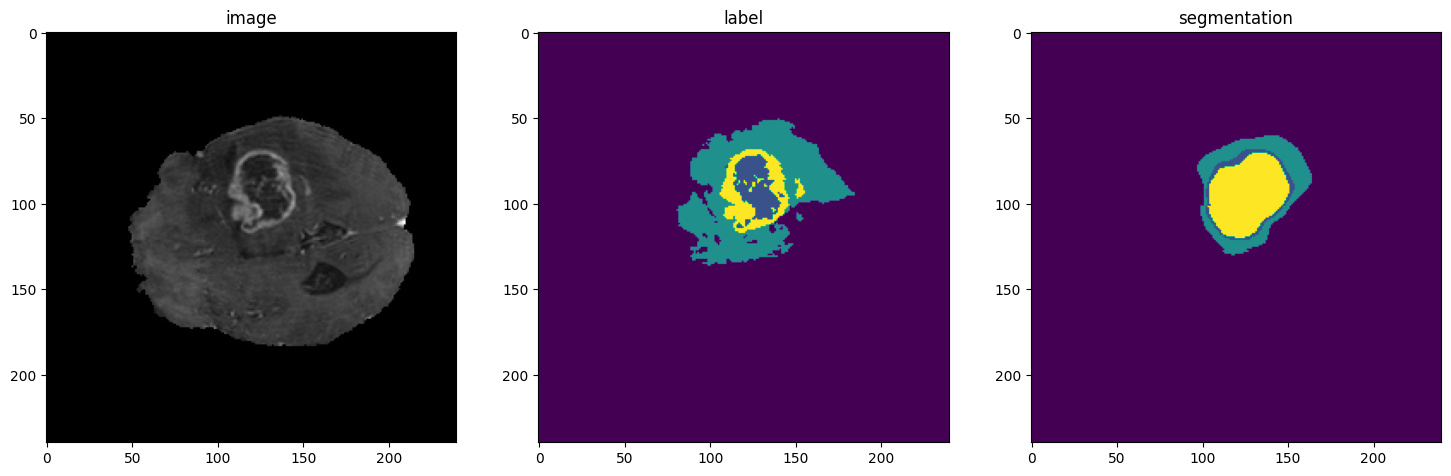

In [21]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1ce.nii",
)
label_add = os.path.join(
    data_dir,
    "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_seg.nii",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)